## Generate synchronization data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set up parameters and fix an initial condition
max_iter = 500
t = np.arange(max_iter)
N = 30
dt = 0.01
phi0 = 2 * np.pi * np.random.rand(N)

W = 5 * np.random.rand(N) # Natural freqs
K = 5 # Coupling
A = np.zeros((N,N))
L = np.zeros((N,N))
deg = np.sum(A,axis=0)
eigSort = sorted(np.linalg.eig(L)[0])
while np.abs( eigSort[1] ) < 1e-5:
    ni = np.random.randint(N)
    nj = np.random.randint(N)
    if (ni != nj) and (A[ni,nj] == 0):
        A[ni,nj] = 1
        A[nj,ni] = 1
        deg[ni] += 1
        deg[nj] += 1
        L = np.diag(deg) - A
        eigSort = sorted(np.linalg.eig(L)[0])
M = int(sum(deg)/2)
D = np.zeros((N,M))
Dind = 0
for i in range(N):
    for j in range(i):
        if A[i,j] > 0:
            D[i,Dind] = 1
            D[j,Dind] = -1
            Dind += 1

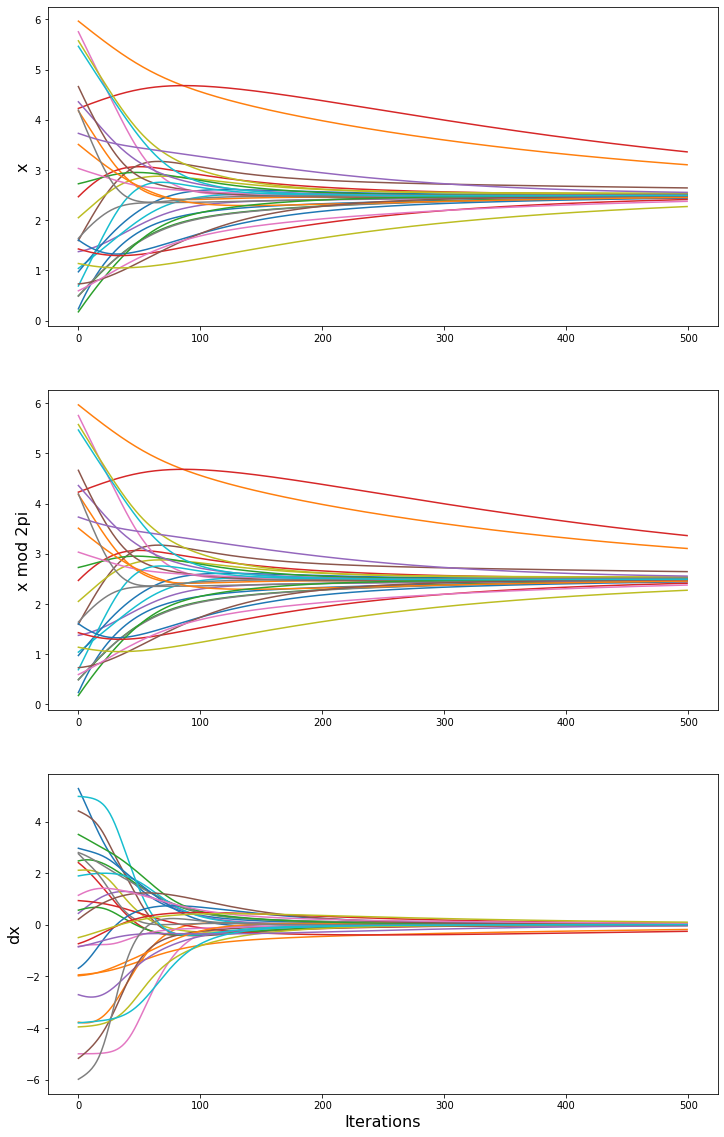

In [2]:
# Run simulation to obtain data. This one takes no input.
x = np.zeros((N,max_iter))
dx = np.zeros((N,max_iter))
u = np.zeros((N, max_iter)) # history of inputs
DTxu = np.zeros((M, max_iter)) # History of D^Tx - u, or should it be D^T(x - u)
fxu = np.zeros((M, max_iter)) # History of f(thea bove)
x[:,0] = phi0
# x[:,0] = phi0 / 10 - np.pi*0.1
# x[15:,0] = phi0[15:]/10 + np.pi*0.9
# x[:10,0] = phi0[:10]/10 - np.pi

# Define input u
u0 = np.zeros((N,))#W#.squeeze()
f = np.tanh

for k in range(max_iter):
    u[:,k] = u0
    # ux = np.zeros((N,1))
    # for i in range(N):
    #     for j,Aij in enumerate(A[i,:]):
    #         if Aij > 0:
    #             ux[i,0] = ux[i,0] + f( x[j,k]-x[i,k] )
    # ux = (W + K * ux).squeeze()
    DTxu[:,k] = np.matmul(D.T, x[:,k] - u[:,k])
    fxu[:,k] = f(DTxu[:,k])
    ux = -np.matmul(D, fxu[:,k])
    dx[:,k] = ux[:]
    if k < max_iter-1:
        x[:,k+1] = x[:,k] + ux * dt
    
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,20))
ax1.plot( t , x.T )
ax2.plot( t , (x % (np.pi*2)).T )
ax3.plot( t , dx.T )
ax3.set_xlabel('Iterations',fontsize=16)
ax1.set_ylabel('x',fontsize=16)
ax2.set_ylabel('x mod 2pi',fontsize=16)
ax3.set_ylabel('dx',fontsize=16)
plt.show()

### See if we can let a network learn the D matrix

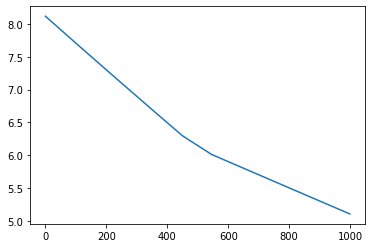

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Build a simple network.
# Input: f(D^Tx), which is of shape (M,1)
# Output: \dot{x}, which is of shape (N,1)
hidden = 32
D_net = nn.Sequential(
    nn.Linear(M, hidden),
    nn.ReLU(),
    nn.Linear(hidden, N),
    nn.ReLU()
)
loss_hist = []
# Regularize it to enforce sparsity: https://discuss.pytorch.org/t/l1-regularization-for-a-single-matrix/28088/2
criterion = nn.functional.mse_loss
optimizer = optim.SGD(D_net.parameters(), lr=1e-3)
input_data = torch.from_numpy(fxu.T.astype('float32'))
output_data = torch.from_numpy(dx.T.astype('float32'))
for e in range(1000):
    optimizer.zero_grad()
    pred = D_net(input_data)
    loss = criterion(pred, output_data)
    
    #l1_norm = torch.norm(D_net[0].weight, p=1)
    #loss += l1_norm
    for W in D_net.parameters():
        loss += W.norm(2)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.detach().numpy())
plt.plot( loss_hist)

In [3]:
# Make some auto-train and auto-test functions
def auto_train(net, inputs, outputs, episode=500, norm_degree=1):
    # Regularize it to enforce sparsity: https://discuss.pytorch.org/t/l1-regularization-for-a-single-matrix/28088/2
    criterion = nn.functional.mse_loss
    optimizer = optim.SGD(net.parameters(), lr=5e-3)

    input_data = torch.from_numpy(inputs.astype('float32'))
    output_data = torch.from_numpy(outputs.astype('float32'))
    
    loss_hist = []
    l1_loss_hist = []
    
    for e in range(episode):
        optimizer.zero_grad()
        pred = net(input_data)
        loss = criterion(pred, output_data)
        loss_hist.append(loss.detach().numpy())
#         l1_loss = loss
#         for W in net.parameters():
#             l1_loss += W.norm(norm_degree)
#         l1_loss.backward()
        if norm_degree > 0:
            for W in net.parameters():
                loss += W.norm(norm_degree)
        elif norm_degree < 0:
            if norm_degree == -1:
                for W in net.parameters():
                    loss += torch.abs(torch.sum(W))
            elif norm_degree == -2:
                for W in net.parameters():
                    loss += torch.sqrt(torch.abs(torch.sum(W*W*torch.sign(W))))
            else:
                for W in net.parameters():
                    loss += torch.abs(torch.sum(torch.abs(W)*torch.sign(W)**norm_degree)**(1./norm_degree))
        loss.backward()
        optimizer.step()
#         l1_loss_hist.append(l1_loss.detach().numpy())
        l1_loss_hist.append(loss.detach().numpy())
    return loss_hist, l1_loss_hist

In [26]:
def plot_train_results(loss_hist, l1_loss_hist, figsize=(7,7), max_plot_loss=0, legend_list=[], title=''):
    fig, (ax1,ax2) = plt.subplots(2, figsize=figsize)
    if len(legend_list) != len(loss_hist):
        legend_list = ['net_{0}'.format(i+1) for i in range(len(loss_hist))]
    for i in range(len(legend_list)):
        ax1.plot(loss_hist[i], label=legend_list[i])
        ax2.plot(l1_loss_hist[i], label=legend_list[i])
    ax1.set_ylabel('Fitting loss between output and target')
    ax2.set_ylabel('Loss including L1 norm of network weight')
    ax2.set_xlabel('Episodes')
    if max_plot_loss > 0:
        ax1.set_ylim(-0.1,max_plot_loss)
        ax2.set_ylim(-0.1,max_plot_loss)
    ax2.legend()
    ax1.legend()
    plt.title(title)
    plt.show()

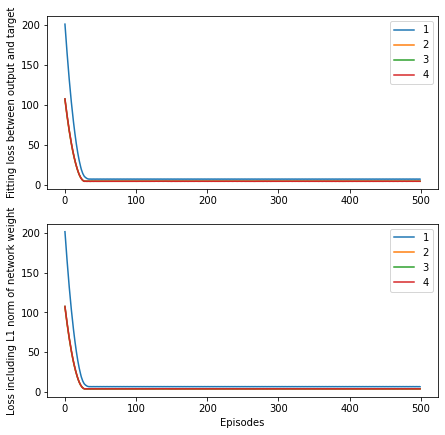

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

# Build a simple network.
# Input: f(D^Tx), which is of shape (M,1)
# Output: \dot{x}, which is of shape (N,1)
# Try different network structures? 
hidden = 32
D_net = nn.Sequential(
    nn.Linear(M, hidden),
    nn.ReLU(),
    nn.Linear(hidden, N),
    nn.ReLU()
)
D_net2 = nn.Linear(M, N)
D_net3 = nn.Sequential(
    nn.Linear(M, N),
    nn.ReLU()
)
D_net4 = nn.Sequential(
    nn.Linear(M, N),
    nn.Tanh()
)
D_list = [D_net, D_net2, D_net3, D_net4]
loss_hist = [[] for D in D_list]
l1_loss_hist = [[] for D in D_list]

# Regularize it to enforce sparsity: https://discuss.pytorch.org/t/l1-regularization-for-a-single-matrix/28088/2
# criterion = nn.functional.mse_loss
# optimizer = [optim.SGD(D.parameters(), lr=5e-3) for D in D_list]

# input_data = torch.from_numpy(fxu.T.astype('float32'))
# output_data = torch.from_numpy(dx.T.astype('float32'))

# for e in range(1500):
#     for i in range(len(D_list)):
#         optimizer[i].zero_grad()
#         pred = D_list[i](input_data)
#         loss = criterion(pred, output_data)
#         l1_loss = loss
#         for W in D_list[i].parameters():
#             l1_loss += W.norm(2)
#         l1_loss.backward()
#         optimizer[i].step()
#         loss_hist[i].append(loss.detach().numpy())
#         l1_loss_hist[i].append(l1_loss.detach().numpy())
# # plt.plot( loss_hist)
# # plt.plot( np.asarray(loss_hist).T)
# # plt.legend(['1','2','3','4'])

loss_hist = []
l1_loss_hist = []
for NN in D_list:
    h1,h2 = auto_train(NN, fxu.T, dx.T, norm_degree=2)
    loss_hist.append(h1)
    l1_loss_hist.append(h2)

fig, (ax1,ax2) = plt.subplots(2, figsize=(7,7))
legend_list = ['1','2','3','4']
plot_ready_loss_hist = np.asarray(loss_hist)
plot_ready_l1_loss_hist = np.asarray(l1_loss_hist)
for i in range(len(plot_ready_loss_hist)):
    ax1.plot(plot_ready_loss_hist[i], label=legend_list[i])
    ax2.plot(plot_ready_l1_loss_hist[i], label=legend_list[i])
ax1.set_ylabel('Fitting loss between output and target')
ax2.set_ylabel('Loss including L1 norm of network weight')
ax2.set_xlabel('Episodes')
ax2.legend()
ax1.legend()

# plot_train_results(np.asarray(loss_hist), np.asarray(l1_loss_hist), figsize=(7,7), 
#                    title='comparison of training loss for different networks')

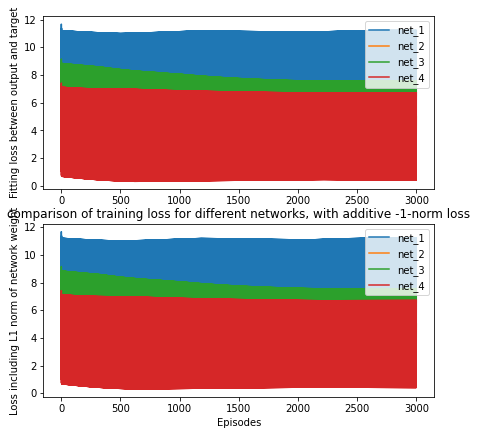

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim

# Build a simple network.
# Input: f(D^Tx), which is of shape (M,1)
# Output: \dot{x}, which is of shape (N,1)
# Try different network structures? 
hidden = 32
D_net = nn.Sequential(
    nn.Linear(M, hidden),
    nn.Tanh(), # nn.ReLU(),
    nn.Linear(hidden, N),
#     nn.ReLU()
)
D_net2 = nn.Linear(M, N)
D_net3 = nn.Sequential(
    nn.Linear(M, hidden),
    nn.Linear(hidden, N) # nn.ReLU()
)
D_net4 = nn.Sequential(
    nn.Linear(M, N),
    nn.Tanh()
)
D_list = [D_net, D_net2, D_net3, D_net4]

loss_hist = []
l1_loss_hist = []
norm_degree = -1
for NN in D_list:
    h1,h2 = auto_train(NN, fxu.T, dx.T, episode=3000, norm_degree=norm_degree)
    loss_hist.append(h1)
    l1_loss_hist.append(h2)

plot_train_results(np.asarray(loss_hist), np.asarray(l1_loss_hist), figsize=(7,7), 
                   title='comparison of training loss for different networks, with additive {0}-norm loss'.format(norm_degree))

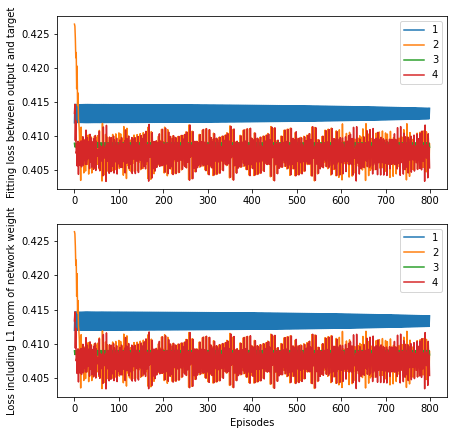

In [11]:

fig, (ax1,ax2) = plt.subplots(2, figsize=(7,7))
legend_list = ['1','2','3','4']
for i in range(len(plot_ready_loss_hist)):
    ax1.plot(plot_ready_loss_hist[i,700:], label=legend_list[i])
    ax2.plot(plot_ready_l1_loss_hist[i,700:], label=legend_list[i])
ax1.set_ylabel('Fitting loss between output and target')
ax2.set_ylabel('Loss including L1 norm of network weight')
ax2.set_xlabel('Episodes')
ax2.legend()
ax1.legend()

In [5]:
def auto_test(net, N, M, max_iter, phi0, f, D, dt, 
              x=None, 
              dx=None, 
              u=None, 
              DTxu=None, 
              fxu=None ):
    if x == None:
        x = np.zeros((N,max_iter))
    if dx == None:
        dx = np.zeros((N,max_iter))
    if u == None:
        u = np.zeros((N,max_iter))
    if DTxu == None:
        DTxu = np.zeros((M,max_iter))
    if fxu == None:
        fxu = np.zeros((M,max_iter))
    x[:,0] = phi0

    u0 = np.zeros((N,))#W#.squeeze()
    for k in range(max_iter):
        u[:,k] = u0
        DTxu[:,k] = np.matmul(D.T, x[:,k] - u[:,k])
        fxu[:,k] = f(DTxu[:,k])
        ux = -np.matmul(D, fxu[:,k])
        dx[:,k] = ux[:]
        if k < max_iter-1:
            x[:,k+1] = x[:,k] + ux * dt
    return [
        x, 
        dx, 
        u, 
        DTxu, 
        fxu
    ]

In [24]:
def plot_test_results(t, x, dx_test, dx_pred, figsize=(12,20), title='Test '):
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=figsize)
    ax1.plot( t , (x % (np.pi*2)) )
    ax2.plot( t , dx_test )
    ax3.plot( t , dx_pred )
    ax3.set_xlabel('Iterations',fontsize=16)
    ax1.set_ylabel('x mod 2pi',fontsize=16)
    ax2.set_ylabel('real derivative dx/dt',fontsize=16)
    ax3.set_ylabel('predicted derivative',fontsize=16)
    ax3.set_ylim(-np.pi*2,np.pi*2)
    plt.title(title)
    plt.show()

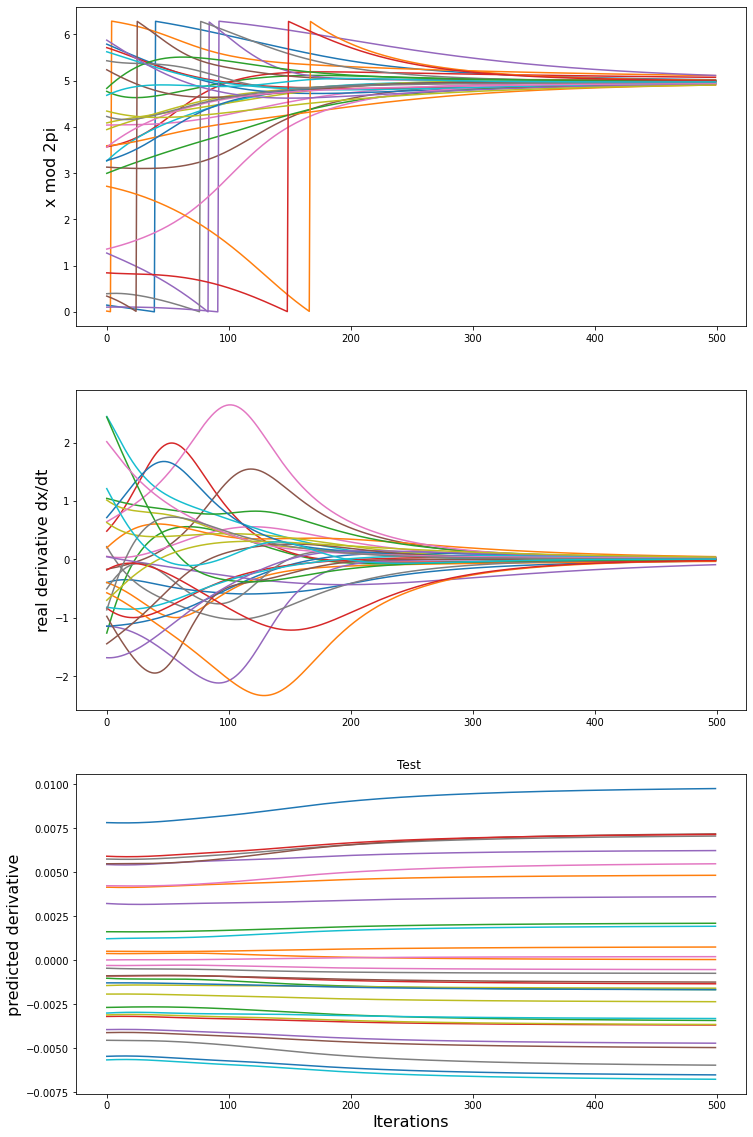

In [62]:
# Verify training performance by generating a different trajectory. This section changes activation function.

# x_test1 = np.zeros((N,max_iter))
# dx_test1 = np.zeros((N,max_iter))
# dx_pred1 = np.zeros((N,max_iter))
# u_test1 = np.zeros((N, max_iter)) # history of inputs
# DTxu_test1 = np.zeros((M, max_iter)) # History of D^Tx - u, or should it be D^T(x - u)
# fxu_test1 = np.zeros((M, max_iter)) # History of f(thea bove)
# x_test1[:,0] = phi0

# u0 = np.zeros((N,))#W#.squeeze()
# f_test1 = np.sin
# NN = D_list[3]

# for k in range(max_iter):
#     u_test1[:,k] = u0
#     DTxu_test1[:,k] = np.matmul(D.T, x_test1[:,k] - u_test1[:,k])
#     fxu_test1[:,k] = f_test1(DTxu_test1[:,k])
#     ux_test1 = -np.matmul(D, fxu_test1[:,k])
#     dx_test1[:,k] = ux_test1[:]
#     dx_pred1[:,k] = NN(torch.from_numpy(fxu_test1[:,[k]].T.astype('float32'))).detach().numpy().squeeze()
#     if k < max_iter-1:
#         x_test1[:,k+1] = x_test1[:,k] + ux_test1 * dt

NN = D_list[3]
test_outputs = auto_test(NN, N, M, max_iter, phi0, np.sin, D, dt)
dx_pred1 = NN(torch.from_numpy(test_outputs[4].T.astype('float32'))).detach().numpy().squeeze().T
        
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,20))
ax1.plot( t , (x_test1 % (np.pi*2)).T )
ax2.plot( t , dx_test1.T )#, label='Real derivative dx/dt' )
ax3.plot( t , dx_pred1.T )
ax3.set_xlabel('Iterations',fontsize=16)
ax1.set_ylabel('x mod 2pi',fontsize=16)
ax2.set_ylabel('real derivative dx/dt',fontsize=16)
ax3.set_ylabel('predicted derivative',fontsize=16)
plt.title('Test ')
plt.show()

# plot_test_results( t,
#     test_outputs[0].T, test_outputs[1].T, dx_pred1.T, 
#     figsize=(12,20), title='Test with activation function sin')

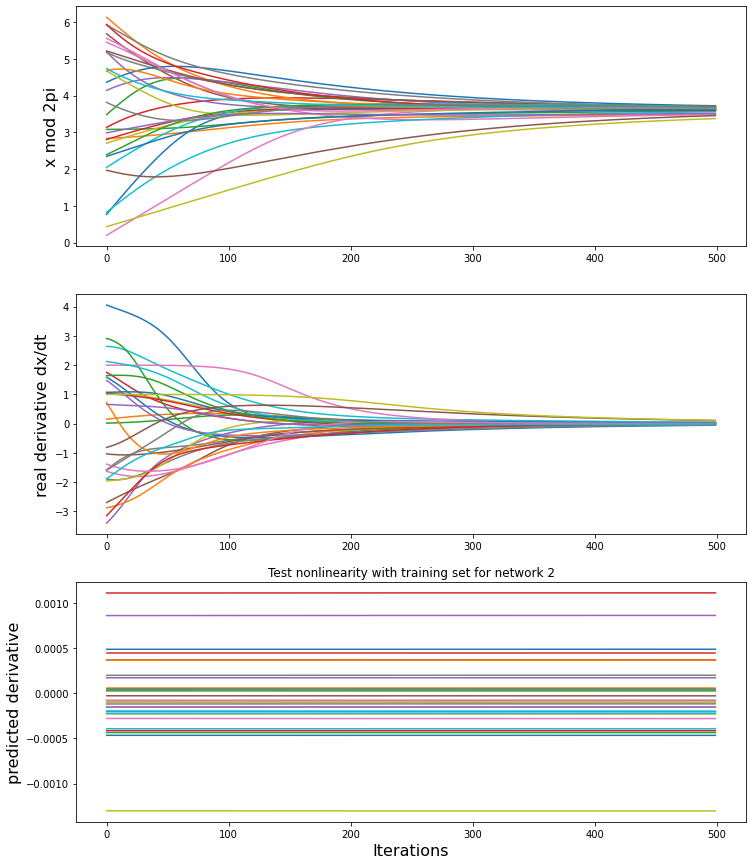

In [40]:
# Verify training performance by using the training set...
nind=2
NN = D_list[nind]
test_outputs = auto_test(NN, N, M, max_iter, phi0, f, D, dt)
dx_pred1 = NN(torch.from_numpy(test_outputs[4].T.astype('float32'))).detach().numpy().squeeze()

plot_test_results( t,
    test_outputs[0].T, test_outputs[1].T, dx_pred1, 
    figsize=(12,15), title='Test nonlinearity with training set for network {0}'.format(nind))

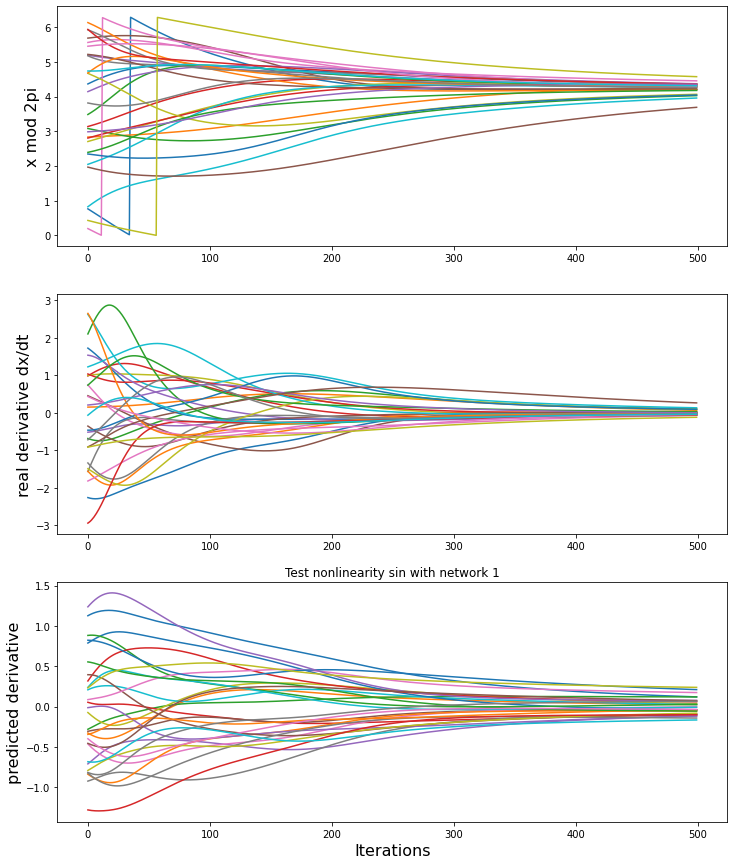

In [44]:
# Verify training performance by generating a different trajectory. This section changes nonlinear function.
nind = 1
NN = D_list[nind]
test_outputs = auto_test(NN, N, M, max_iter, phi0, np.sin, D, dt)
dx_pred1 = NN(torch.from_numpy(test_outputs[4].T.astype('float32'))).detach().numpy().squeeze()

plot_test_results( t,
    test_outputs[0].T, test_outputs[1].T, dx_pred1, 
    figsize=(12,15), title='Test nonlinearity sin with network {0}'.format(nind))

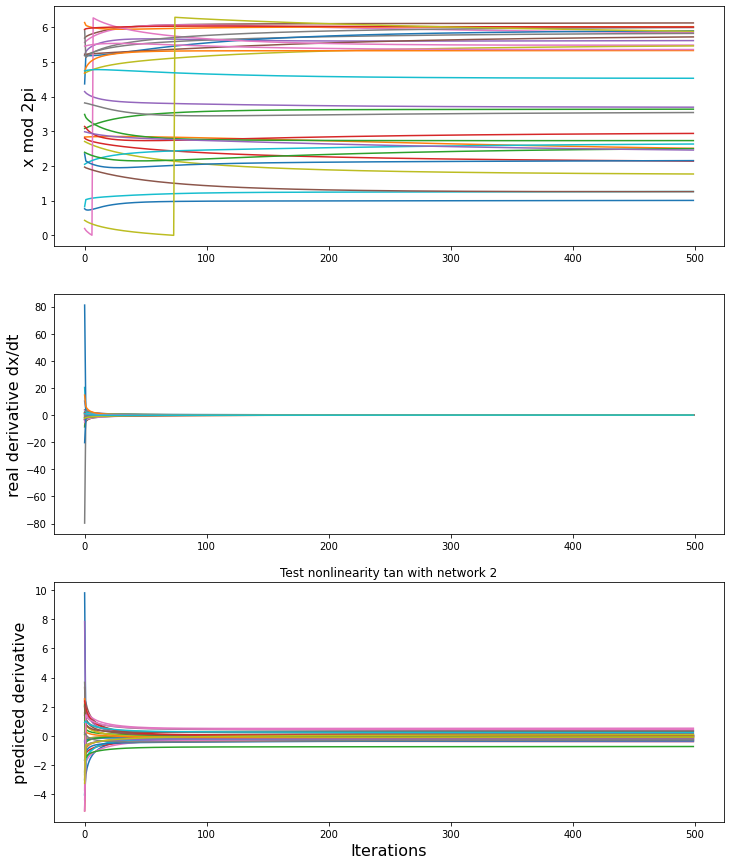

In [51]:
# Verify training performance by generating a different trajectory. This section changes nonlinear function.
nind=2
NN = D_list[nind]
test_outputs = auto_test(NN, N, M, max_iter, phi0, np.sin, D, dt)
dx_pred1 = NN(torch.from_numpy(test_outputs[4].T.astype('float32'))).detach().numpy().squeeze()

plot_test_results( t,
    test_outputs[0].T, test_outputs[1].T, dx_pred1, 
    figsize=(12,15), title='Test nonlinearity sin with network {0}'.format(nind))

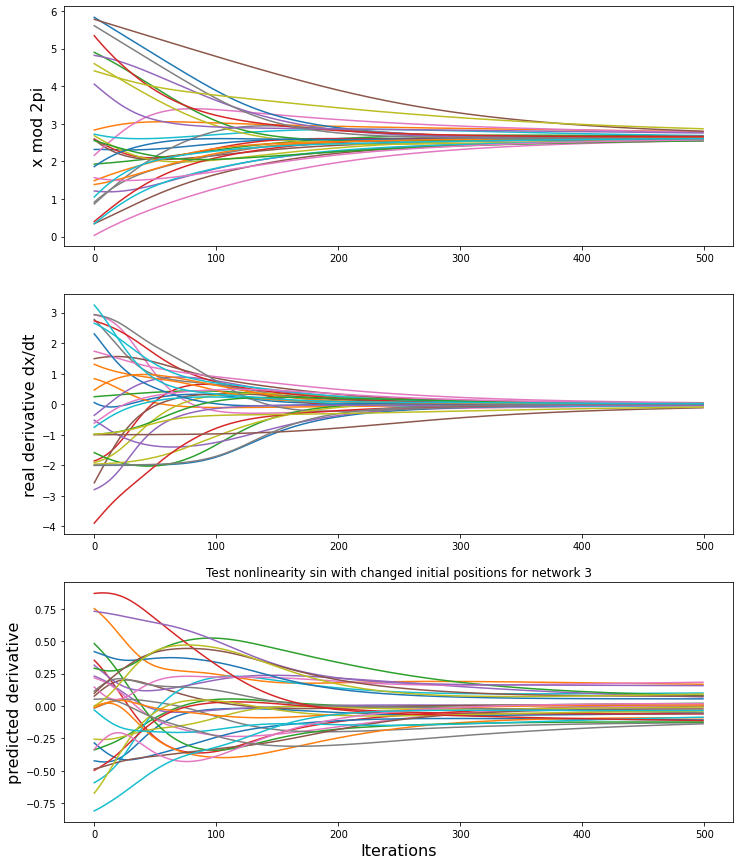

In [52]:
# Verify training performance by generating a different trajectory. This section changes initial condition.
nind=3
NN = D_list[nind]
test_outputs = auto_test(NN, N, M, max_iter, 2 * np.pi * np.random.rand(N), f, D, dt)
dx_pred1 = NN(torch.from_numpy(test_outputs[4].T.astype('float32'))).detach().numpy().squeeze()

plot_test_results( t,
    test_outputs[0].T, test_outputs[1].T, dx_pred1, 
    figsize=(12,15), title='Test nonlinearity sin with changed initial positions for network {0}'.format(nind))

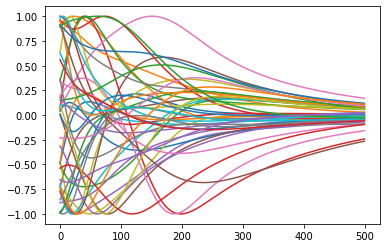

In [26]:
plt.plot(t, test_outputs[4].T)

In [54]:
# Interpret the learned model
nind=2
NN = D_list[nind]
D_pred = np.zeros((N,M))
for i in range(M):
    basis_i = np.zeros((1,M))
    basis_i[0,i] = 1
    D_pred[:,i] = NN(torch.from_numpy(basis_i.astype('float32'))).detach().numpy().squeeze()
print(D_pred, D)

[[ 0.12366237  0.12990411 -0.20187645 ... -0.00310397  0.03184736
  -0.20144263]
 [-0.00697771  0.12279233 -0.00267206 ...  0.03514658 -0.03454626
   0.08508718]
 [ 0.04550906  0.00500309  0.04303116 ...  0.00831136 -0.0478808
   0.0029147 ]
 ...
 [ 0.04641838  0.00135401  0.16177635 ...  0.07773704  0.08036027
   0.18531325]
 [ 0.18666306  0.15154062  0.26416138 ...  0.20569974  0.17211163
   0.21757829]
 [-0.2094173  -0.11882086 -0.01294208 ... -0.08547011 -0.09955955
  -0.05603519]] [[-1.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  1.  1.]]


In [62]:
L_pred = np.matmul(D_pred, D_pred.T)
w_pred, v_pred = np.linalg.eig(L_pred)
w,v = np.linalg.eig(L)
print(sorted(w_pred))
print(sorted(w))

[0.0001169838917076444, 0.00019778166425138402, 0.0007116324131554202, 0.00245223501038757, 0.002942016101516335, 0.004776401476033756, 0.007197768262007042, 0.010983078063957267, 0.01360970169801029, 0.014862404990015869, 0.02067428222365343, 0.026452623082497143, 0.038796595899097064, 0.049208260321312945, 0.061492180683965225, 0.07330350082819632, 0.07808993090883919, 0.10350132482400276, 0.12337137041229657, 0.13196421638713005, 0.14848177277496635, 0.1635986702521364, 0.20024636707093388, 0.2509461712717051, 0.2575357856047155, 0.30345431409757156, 0.3950467390294716, 0.6383094631461527, 3.6721673474283794, 8.536854047583343]
[-2.225685830255176e-16, 0.27630403431733597, 0.5269562568968756, 0.6416802339768216, 0.6594520093626793, 0.8781226508389899, 0.9873363668874895, 1.1237121218865356, 1.3240351141616309, 1.4022101245490197, 1.4984688270352897, 1.6816032021410732, 2.14105795499352, 2.38641430100414, 2.5619858209048436, 2.9474869841660887, 3.013591832492212, 3.269117458274957, 3

In [ ]:
# Need to consider normalizing the states

In [ ]:
# You can consider imposing a constraint on the sum of network weights as an additional loss term... L1 but not necessarily positive

In [ ]:
# Not sure why all of the weights seem to be very small (otherwise how do you explain why all nets have similar 
# loss because the resulting outputs are all really small and near-zero, even though shapes are so different?)

In [ ]:
testnp1 = np.arange(12).reshape((3,4))*100
testnp2 = np.arange(12).reshape((3,4))
testnp1.reshape((3,4,1)) + testnp2.reshape((3,1,4))

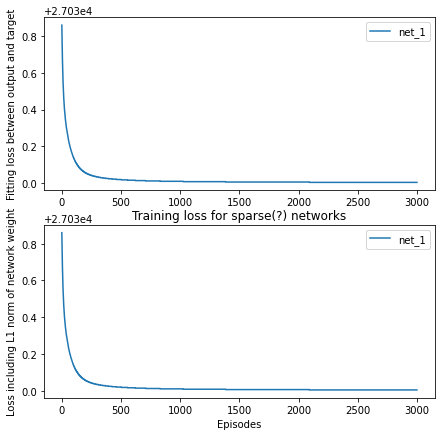

In [20]:
# Try some training schemes for SymNet
# Step 1: Generate all possible differences between agents
xdiff = x.T.reshape((-1,N,1)) - x.T.reshape((-1,1,N)) # Size: (B,N,N)
xdiff = xdiff.reshape((-1,N*N))
# Step 2: Generate the nonlinearity for each possible pair
fxdiff = f(xdiff)
# Step 3: Do some training
D_net = nn.Linear(N*N, N)

def sparse_train(net, inputs, outputs, episode=500, norm_degree=1):
    # Regularize it to enforce sparsity: https://discuss.pytorch.org/t/l1-regularization-for-a-single-matrix/28088/2
    criterion = nn.functional.mse_loss
    optimizer = optim.SGD(net.parameters(), lr=5e-3)

    input_data = torch.from_numpy(inputs.astype('float32'))
    output_data = torch.from_numpy(outputs.astype('float32'))
    
    loss_hist = []
    l1_loss_hist = []
    
    for e in range(episode):
        optimizer.zero_grad()
        pred = net(input_data)
        loss = criterion(pred, output_data)
        loss_hist.append(loss.detach().numpy())
        for W in net.parameters():
            loss += W.norm(norm_degree)
        loss.backward()
        optimizer.step()
        l1_loss_hist.append(loss.detach().numpy())
        # Alt option: Clamp the network weights
    return loss_hist, l1_loss_hist

h1,h2 = sparse_train(D_net, fxdiff, dx.T, episode=3000, norm_degree=0)
loss_hist = []
l1_loss_hist = []
loss_hist.append(h1)
l1_loss_hist.append(h2)
plot_train_results(np.asarray(loss_hist), np.asarray(l1_loss_hist), figsize=(7,7), max_plot_loss=10,
                   title='Training loss for sparse(?) networks')

In [39]:
loss_hist[0][0]

array(27030.86, dtype=float32)

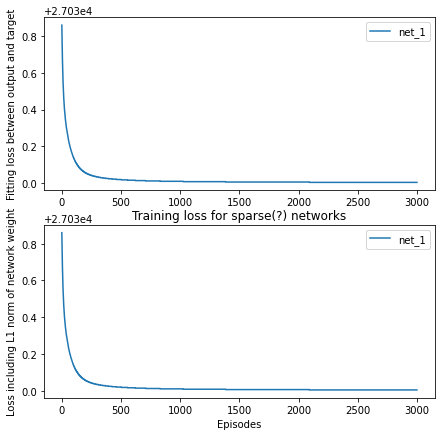

In [35]:
plot_train_results(np.asarray(loss_hist), np.asarray(l1_loss_hist), figsize=(7,7), max_plot_loss=0,
                   title='Training loss for sparse(?) networks')

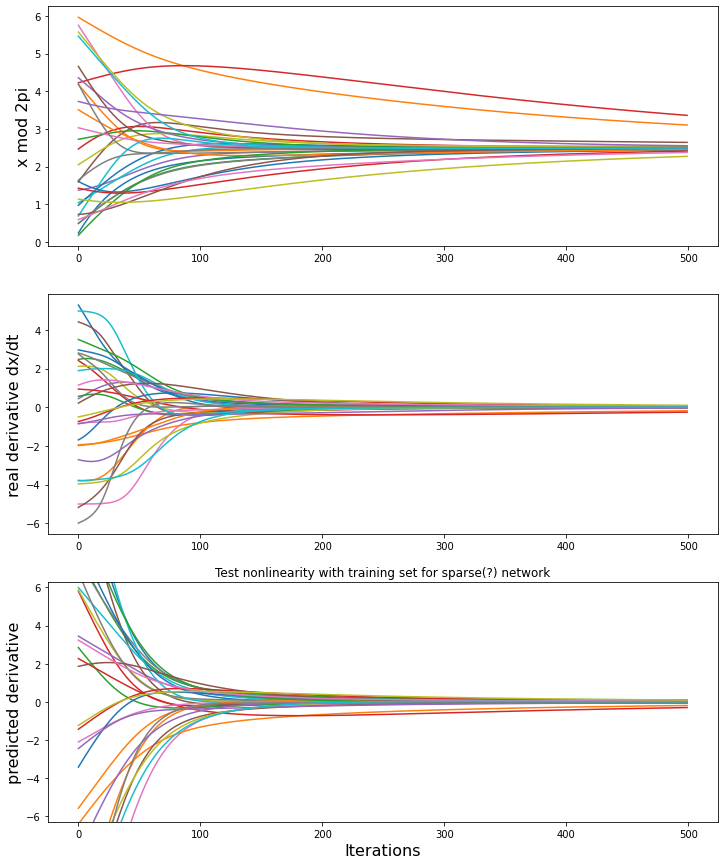

In [25]:
test_outputs = auto_test(D_net, N, M, max_iter, phi0, f, D, dt)
test_xdiff = test_outputs[0].T.reshape((-1,N,1)) - test_outputs[0].T.reshape((-1,1,N))
test_xdiff = test_xdiff.reshape((-1,N*N))
dx_pred1 = D_net(
    torch.from_numpy(test_xdiff.astype('float32'))
).detach().numpy().squeeze()

plot_test_results( t,
    test_outputs[0].T, test_outputs[1].T, dx_pred1, 
    figsize=(12,15), title='Test nonlinearity with training set for sparse(?) network')

In [9]:
# Build a network that is kind of symmetric? Or uses the same layer for D-related operations? 
class SymNet(nn.Module):
    def __init__(self, N, hidden, f=torch.tanh):
        super(SymNet, self).__init__()
        self.N = N # Number of agents
        self.hidden = hidden
        self.f = f
        self.fc = nn.Linear(self.hidden, self.N)
#         self.fc = nn.Linear(self.N, self.hidden) # D^T representation - takes in N and outputs M; shape = (M,N)

    def forward(self, x):
        # Shape of the two arguments below: MxN (takes in N, outputs M); BxNx1 (expanded from BxN). Desired output is Bx(Mx1).
        # Reference to this manipulation is here: https://pytorch.org/docs/stable/generated/torch.matmul.html
        # How to implement D^T from D? https://discuss.pytorch.org/t/transpose-of-linear-layer/12411/4
        DTx = torch.matmul(self.fc.weight.t(), x.unsqueeze(2))
        fDTx = self.f(DTx).squeeze()
        xdot = self.fc(fDTx)
        return xdot

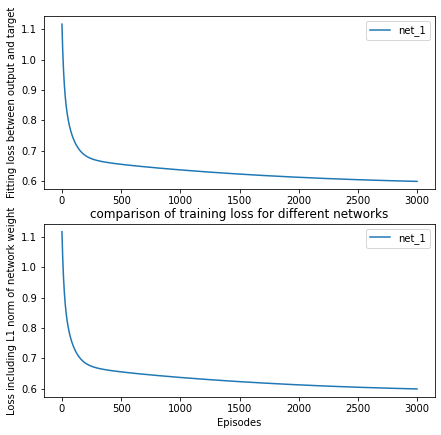

In [10]:
D_sym = SymNet(N,M) # NOTE: Can't put numpy function as nonlinearity in pytorch network
loss_hist = []
l1_loss_hist = []
h1,h2 = auto_train(D_sym, x.T, dx.T, episode=3000, norm_degree=0)
loss_hist.append(h1)
l1_loss_hist.append(h2)

plot_train_results(np.asarray(loss_hist), np.asarray(l1_loss_hist), figsize=(7,7), 
                   title='comparison of training loss for different networks')

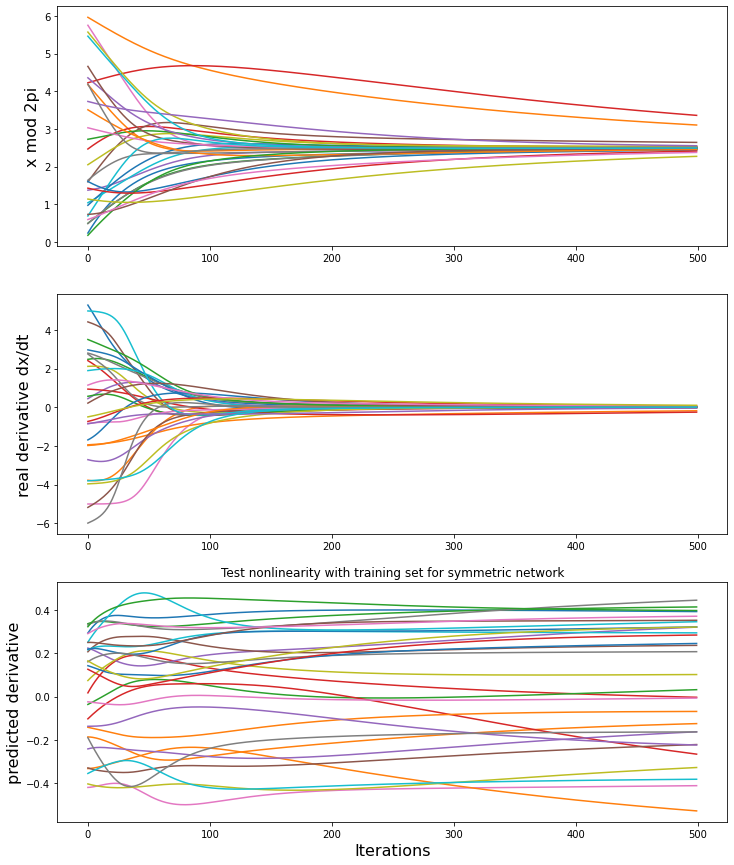

In [11]:
test_outputs = auto_test(D_sym, N, M, max_iter, phi0, f, D, dt)
dx_pred1 = D_sym(torch.from_numpy(test_outputs[0].T.astype('float32'))).detach().numpy().squeeze()

plot_test_results( t,
    test_outputs[0].T, test_outputs[1].T, dx_pred1, 
    figsize=(12,15), title='Test nonlinearity with training set for symmetric network')

In [69]:
D_sym.fc.weight.t().shape

torch.Size([30, 45])

In [87]:
torch.from_numpy(test_outputs[4].T.astype('float32')).unsqueeze(2).shape

torch.Size([500, 45, 1])

In [90]:
torch.from_numpy(x.T.astype('float32')).unsqueeze(2).shape

torch.Size([500, 30, 1])

In [92]:
f

<ufunc 'tanh'>